In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image


T = 0.5
lr = 1e-4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.CIFAR10('~/.pytorch/CIFAR10/',
                            download=True, train=True, transform=transform)
training_loader = torch.utils.data.DataLoader(
    trainset, batch_size=8, shuffle=True)

testset = datasets.CIFAR10('~/.pytorch/CIFAR10/',
                           download=True, train=False, transform=transform)
validation_loader = torch.utils.data.DataLoader(
    testset, batch_size=8, shuffle=True)
# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Report split sizes
print('Training set has {} instances'.format(len(trainset)))
print('Validation set has {} instances'.format(len(testset)))


Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


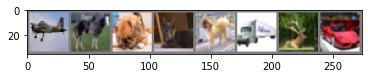

plane


In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(1)))


In [3]:
def softmax_T(inputs, T):

    exp_values = (inputs / T).exp()
    probabilities = exp_values / torch.sum(exp_values, 1, True)
    return probabilities.log()


def my_cross_entropy(x, y, T):
    log_prob = -1.0 * softmax_T(x, T)
    loss = log_prob.gather(1, y.unsqueeze(1))
    loss = loss.mean()
    return loss


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(7, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()


In [5]:
def train_one_epoch(epoch_index, tb_writer, T, lr):
    running_loss = 0.
    last_loss = 0.
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = my_cross_entropy(outputs, labels, T)
        loss.backward()
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss


In [6]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
EPOCHS = 4

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, T, lr)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = model(vinputs)
        vloss = my_cross_entropy(voutputs, vlabels, T)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1


EPOCH 1:
  batch 1000 loss: 2.303182182788849
  batch 2000 loss: 2.2990466537475585
  batch 3000 loss: 2.294389825105667
  batch 4000 loss: 2.281265454053879
  batch 5000 loss: 2.25018079662323
  batch 6000 loss: 2.181967474579811
LOSS train 2.181967474579811 valid 2.1139919757843018
EPOCH 2:
  batch 1000 loss: 2.0819077105522155
  batch 2000 loss: 2.022409469246864
  batch 3000 loss: 1.9802639470100403
  batch 4000 loss: 1.9275733256340026
  batch 5000 loss: 1.8951534200906754
  batch 6000 loss: 1.8428990205526352
LOSS train 1.8428990205526352 valid 1.8220360279083252
EPOCH 3:
  batch 1000 loss: 1.8233302775621414
  batch 2000 loss: 1.786982926607132
  batch 3000 loss: 1.7600487434864045
  batch 4000 loss: 1.7108327242136
  batch 5000 loss: 1.723951198220253
  batch 6000 loss: 1.664424441576004
LOSS train 1.664424441576004 valid 1.6337491273880005
EPOCH 4:
  batch 1000 loss: 1.636573268890381
  batch 2000 loss: 1.6188817067146302
  batch 3000 loss: 1.6086994935274124
  batch 4000 loss

In [7]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validation_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


embeddings = []
targets = []
with torch.no_grad():
    for i, data in enumerate(validation_loader):
        images, labels = data[0].to(device), data[1].to(device)
        embeddings.append(model(images).cpu().detach().numpy())
        targets.append(labels.cpu().detach().numpy())

flattened_emb = [val for sublist in embeddings for val in sublist]
flattened_target = [val for sublist in targets for val in sublist]


Accuracy of the network on the 10000 test images: 43 %


In [8]:
tsne = TSNE(n_components=2, verbose=1, random_state=21, n_iter=700)
tsne_proj = tsne.fit_transform(flattened_emb)

df = pd.DataFrame()
df['x'] = tsne_proj[:, 0]
df['y'] = tsne_proj[:, 1]
df['label'] = flattened_target


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 0.657s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.306684
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.303261
[t-SNE] KL divergence after 700 iterations: 1.921681


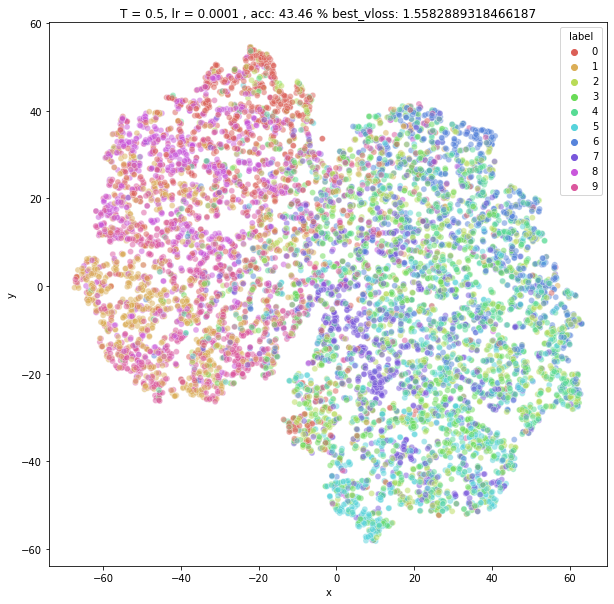

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
plot_path = f'plots/{timestamp}.png'

plt.figure(figsize=[10, 10])
sns.scatterplot(data=df, x="x", y="y", alpha=0.5, hue='label', palette=sns.color_palette(
    "hls", 10)).set(title=f"T = {T}, lr = {lr} , acc: {100 * correct / total} % best_vloss: {best_vloss}")
plt.savefig(plot_path)


In [36]:
scores = pd.read_csv("scores.csv")
scores.loc[len(scores.index)] = [T, lr, round(correct / total * 100, 3), best_vloss.item(), plot_path]
scores.to_csv("scores.csv", index=False)


In [37]:
scores.head()

T-value  learning_rate  accuracy  best_vloss                  plot_path
0      0.1          0.001     58.70    1.153903  plots/20220329_113912.png
1      0.5          0.001     61.46    1.092955  plots/20220329_114207.png
2      1.0          0.001     60.68    1.111146  plots/20220329_114524.png
3      5.0          0.001     51.21    1.353349  plots/20220329_114926.png
4     10.0          0.001     42.33    1.541313  plots/20220329_115240.png

In [38]:
import glob
filenames = glob.glob("losses\*.csv")
losses = pd.DataFrame(columns = ['Wall time', 'Step','Value', 'name'])

for name in filenames:
    tmp = pd.read_csv(name)
    tmp['name'] = name[7:-4]
    losses = pd.concat([losses, tmp])


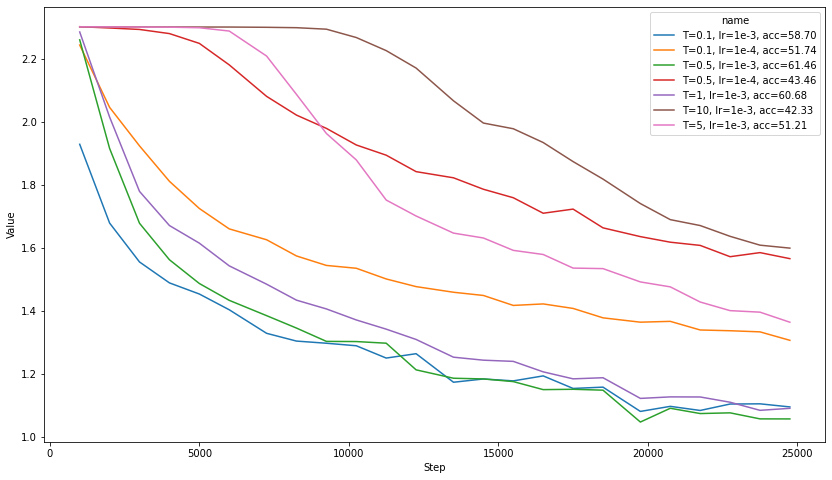

In [39]:
plt.figure(figsize=[14, 8])
sns.lineplot(data=losses, x="Step", y="Value", hue="name")
plt.show()

In [46]:
scores['plot_path']

0    plots/20220329_113912.png
1    plots/20220329_114207.png
2    plots/20220329_114524.png
3    plots/20220329_114926.png
4    plots/20220329_115240.png
5    plots/20220329_115828.png
6    plots/20220329_120321.png
7    plots/20220329_120321.png
Name: plot_path, dtype: object

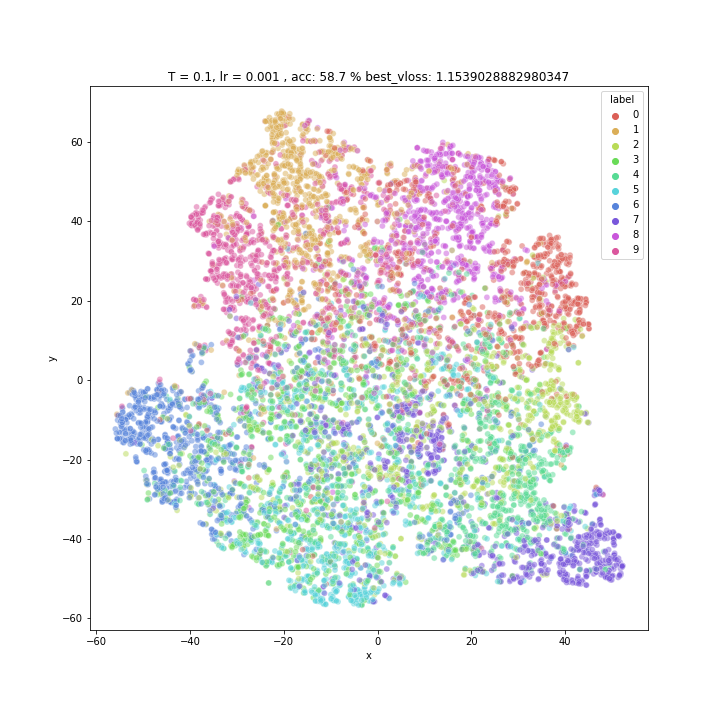

In [47]:
Image(scores.loc[0,"plot_path"])

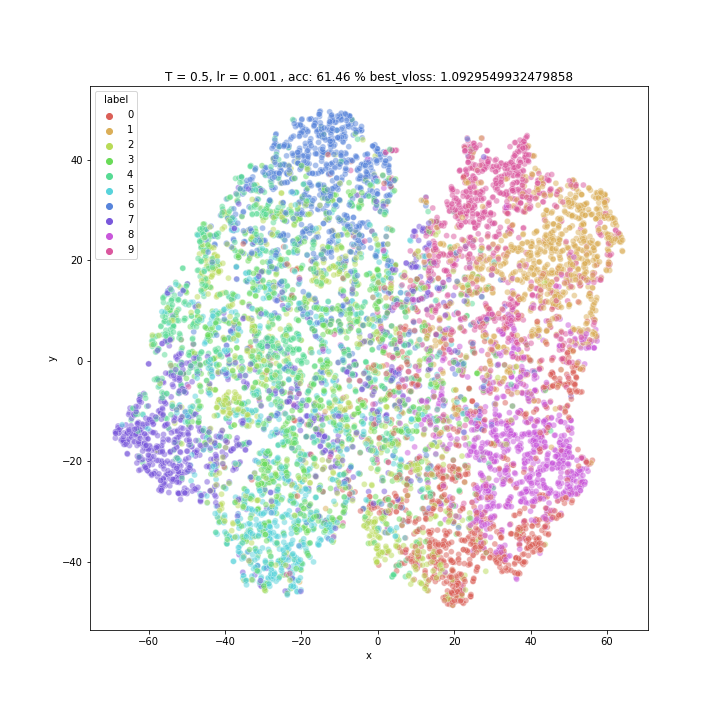

In [48]:
Image(scores.loc[1,"plot_path"])

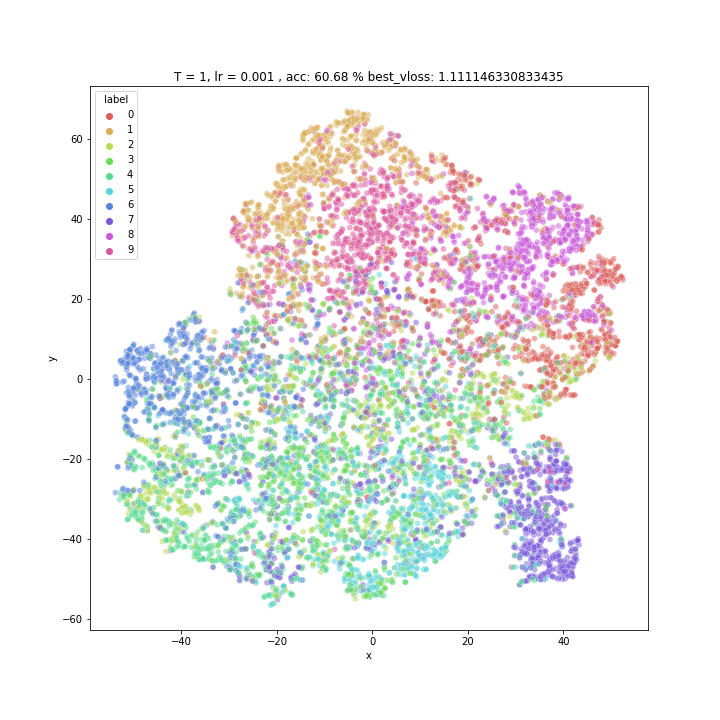

In [49]:
Image(scores.loc[2,"plot_path"])

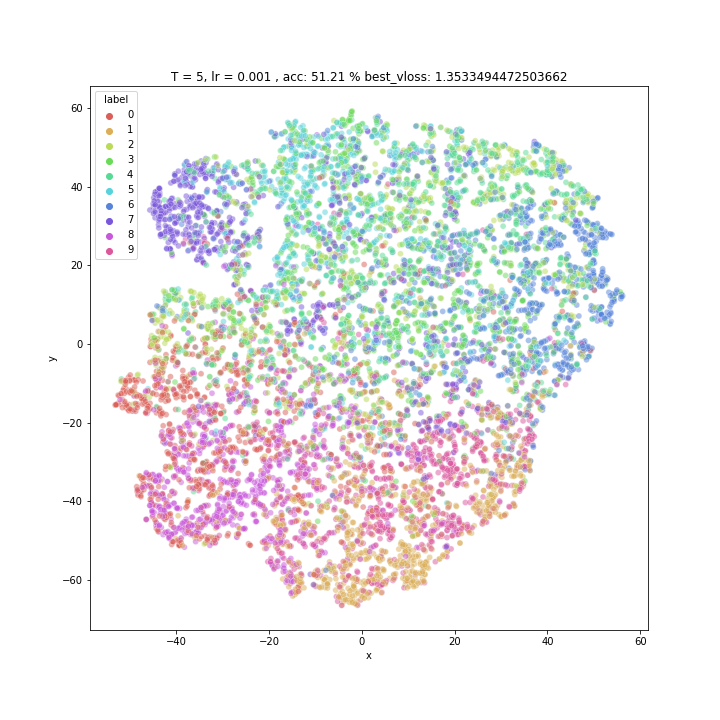

In [50]:
Image(scores.loc[3,"plot_path"])

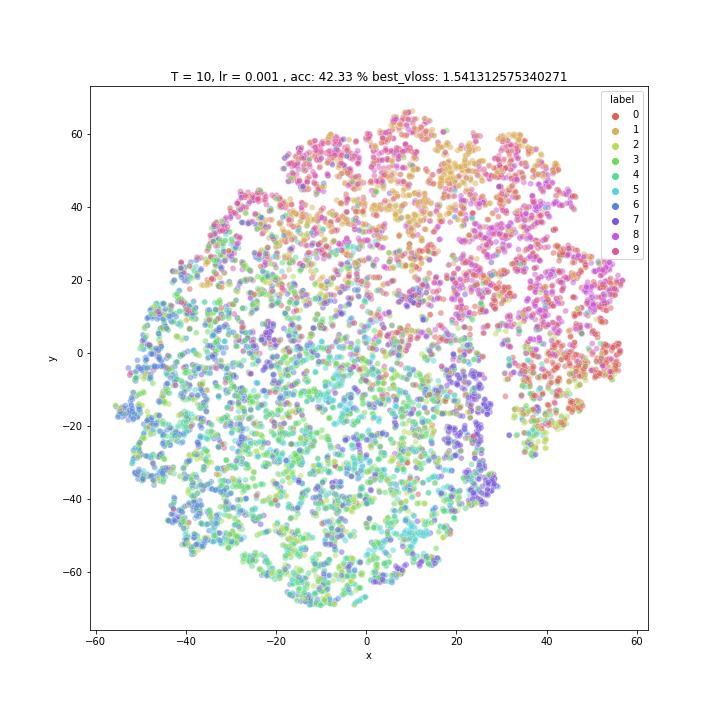

In [51]:
Image(scores.loc[4,"plot_path"])

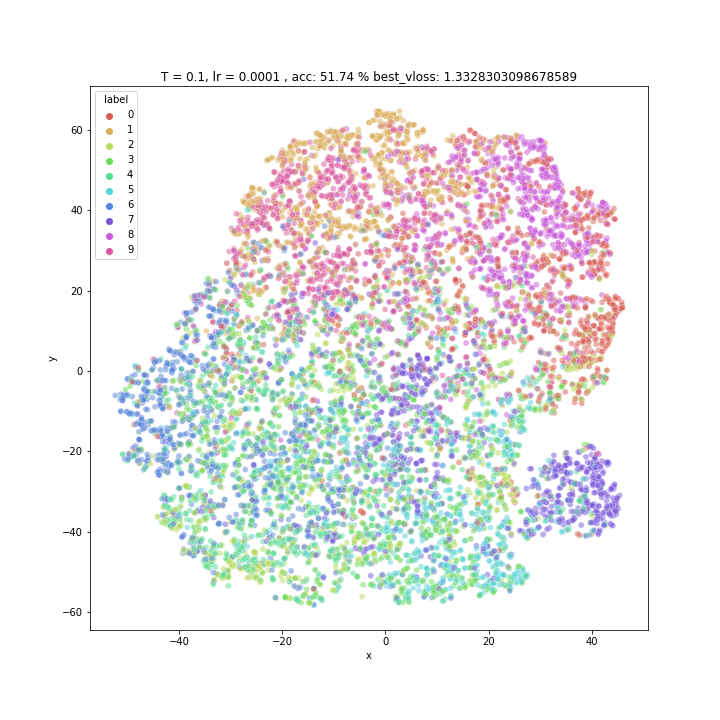

In [52]:
Image(scores.loc[5,"plot_path"])

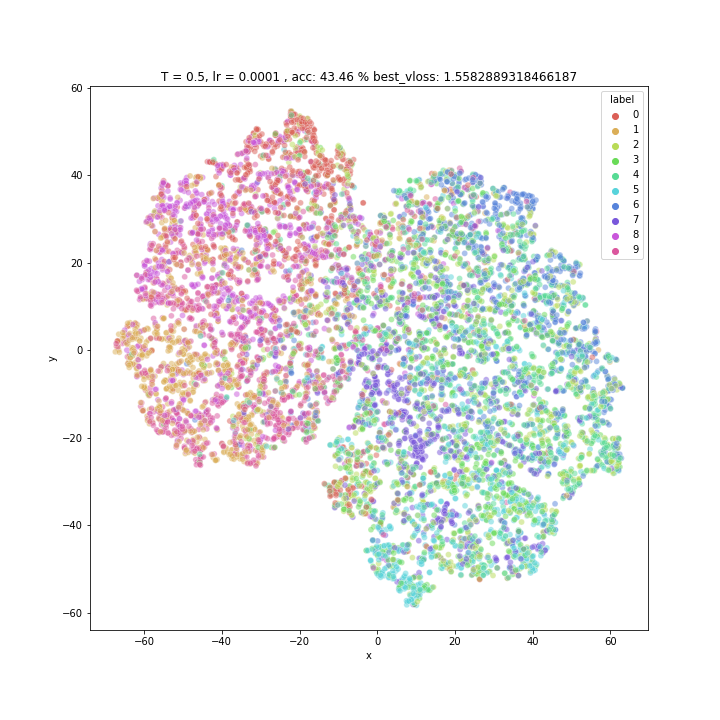

In [53]:
Image(scores.loc[6,"plot_path"])

In [56]:
scores.sort_values('accuracy', ascending=False)

T-value  learning_rate  accuracy  best_vloss                  plot_path
1      0.5         0.0010     61.46    1.092955  plots/20220329_114207.png
2      1.0         0.0010     60.68    1.111146  plots/20220329_114524.png
0      0.1         0.0010     58.70    1.153903  plots/20220329_113912.png
5      0.1         0.0001     51.74    1.332830  plots/20220329_115828.png
3      5.0         0.0010     51.21    1.353349  plots/20220329_114926.png
6      0.5         0.0001     43.46    1.558289  plots/20220329_120321.png
7      0.5         0.0001     43.46    1.558289  plots/20220329_120321.png
4     10.0         0.0010     42.33    1.541313  plots/20220329_115240.png

# Summary
The best result was obtained for T = 0.5, learning rate = 1e-3. *Accuracy = 61.46*

The second best results was obtained for T = 1 and learning rates = 1e-3 *Accuracy = 60.68*

The third best result was obtained for T = 0.1, learning rate=1e-3 *Accuracy = 58.70*

The appearance of a TSNE graph depends most on the accuracy score. The better the accuracy score, the more separated the embeddings are.